In [9]:
from RCNNModel_Parking import RCNNModel
import matplotlib.pyplot as plt
from matplotlib import path
import numpy as np
import cv2
import math, time, glob
%matplotlib inline

In [10]:
class DataAnalysis():
    
    def helper_calcCentroid(self, topCoord, btmCoord):
        w = btmCoord[0] - topCoord[0]
        h = btmCoord[1] - topCoord[1]
        return [(topCoord[0]+w/2), (topCoord[1]+h/2)]
    
    def showPixelFreeSpaceGraph(self, freePixelSpaceArray, totalTime):      
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "FreePixelSpace: ", freePixelSpaceArray
        
        plt.title("Free Space in Pixels")
        axis = [-20, (totalTime+1)*16, 150, 600]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (pixels)')
        
        plt.plot(secondInterval[1:], freePixelSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freePixelSpaceArray[1:], 'bo')
        
        plt.plot((axis[0], axis[1]), (300, 300), 'r--')
        plt.plot((axis[0], axis[1]), (475, 475), 'r--')
        plt.plot((axis[0], axis[1]), (789, 789), 'r--')
        plt.plot((axis[0], axis[1]), (1052, 1052), 'r--')
    
    ###RawX Coordinates
    def convertRawXCoordToDist(self, freeSpaceArray, multiplyFactor):
        pairNum = 0
        totalFtinRawDist = 0
        while pairNum < len(freeSpaceArray):
            dist = freeSpaceArray[pairNum+1] - freeSpaceArray[pairNum]
            if dist < 0:
                print "DIST WAS NEGATIVE. SETTING TO 0"
                dist = 0
            print "raw dist: ", dist
            rawDistFtperPx = dist*multiplyFactor
            print "rawDistFtperPx: ", rawDistFtperPx
            totalFtinRawDist += rawDistFtperPx
            pairNum += 2
        print "Total Feet for Raw Dist: ", totalFtinRawDist
        return totalFtinRawDist
    
    def showRawDistFreeSpaceGraph(self, freeRawDistSpaceArray, totalTime):
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "FreePixelSpace: ", freeRawDistSpaceArray
        
        plt.title("Free Space in Feet (Raw Coordinates)")
        axis = [-20, (totalTime+1)*16, 10, 45]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        plt.plot(secondInterval[1:], freeRawDistSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freeRawDistSpaceArray[1:], 'bo')
        
        plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (20, 20), 'r--')
        plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (40, 40), 'r--')
    
    ###Estimated Coordinates
    def pixelsToEstCoord(self, freeSpaceArray):
        extrapArray = []
        for xcoord in freeSpaceArray:
            extrapArray.append(self.extrapCoordinates(xcoord))
        print "extrapArray: ", extrapArray
        return extrapArray
        
    def extrapCoordinates(self, raw_x_coord):
#         w_factor = [ -6.41328433e-04,   3.65880005e-07,   1.26635656e+00] #For the Ames St Parking
        w_factor = [  9.89468130e-05,  -2.32858803e-08,   9.34503401e-01] #For the goPro Bleacher
        inputArray = np.array([raw_x_coord, raw_x_coord**2, 1])
        calculatedScaleFactor = inputArray.dot(w_factor)
        projectedCoordinate = raw_x_coord*calculatedScaleFactor
        return projectedCoordinate
    
    def showEstDistFreeSpaceGraph(self, freeEstDistSpaceArray, totalTime, time):
        totalTime = totalTime
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "EstimatedPixelSpace: ", freeEstDistSpaceArray
        
        plt.figure(figsize=(10, 8))
        plt.title("Estimated Coordinates Free Space in Feet at {0}".format(time))
        axis = [-20, (totalTime+1)*16, 0, 85]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        plt.plot(secondInterval[1:], freeEstDistSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freeEstDistSpaceArray[1:], 'bo')
        
        plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (20, 20), 'r--')
        plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (40, 40), 'r--')
        plt.text((totalTime+1)*12, 58, r'3 Empty Spot')
        plt.plot((axis[0], axis[1]), (60, 60), 'r--')
        plt.text((totalTime+1)*12, 78, r'4 Empty Spot')
        plt.plot((axis[0], axis[1]), (80, 80), 'r--')
#         plt.savefig("FCRNN{0}_17ft_15fps_sp0-4.png".format(time))

    def allPixelsToEstCoord(self, freeSpaceArray):
        largeArray = []
        for xcoord in freeSpaceArray:
            extrapArray = []
            for x in range(len(xcoord)):
                extrapArray.append(analysis.extrapCoordinates(xcoord[x]))
            largeArray.append(extrapArray)
        print "largeArray: ", largeArray
        return largeArray
        

In [11]:
class Video():

#     def __init__(self, videoPath):
#         self.videoPath = videoPath
        
    def turnImg(self, image):
        rows, cols, color = image.shape
#         M = cv2.getRotationMatrix2D((cols/2, rows/2), 2, 1) #For Ames St Parking
        M = cv2.getRotationMatrix2D((cols/2, rows/2), -2, 1) #For goPro Parking
        dst = cv2.warpAffine(image, M, (cols, rows))
        return dst
        
    def detectCars(self, netmodel):
        frame_detections = []            
        dets = netmodel.carDetectionMethod(rotate)
        for det in dets:
            bbox = det[:4]
            if (bbox[2]-bbox[0])<700:
                if bbox[3] < 721:
                    frame_detections.append(bbox)
                    cv2.rectangle(rotate,(bbox[0], bbox[1]),(bbox[2], bbox[3]), (0, 255, 0), 3 )
                else:
                    cv2.rectangle(rotate,(bbox[0], bbox[1]),(bbox[2], bbox[3]), (255, 0, 0), 3 )
        
        cv2.line(rotate, (0,721), (1920,721), (255, 0, 0), 3)
        return frame_detections
    
    #Note: If the spots are not physically marked (free space), create another method that color 
    #codes the empty space between the spaces
    def drawSpotsOccupyStatus(self, copyImg):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if spot.occupyStatus == "available":
                cv2.polylines(copyImg, [spot.staticBbox], False, (0,255, 0), 3)
            else:
                cv2.polylines(copyImg, [spot.staticBbox], False, (255, 0, 0), 3)
                
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = "ID: {0}, Occ: {1}, Stat: {2}".format(spot.ID, spot.occlusion, spot.occupyStatus)
            cv2.putText(copyImg,text, (spot.staticBbox[0][0], spot.staticBbox[0][1]), font, 0.5,(0,0,255),2)
            
    def drawAvgCenterAndBox(self, image):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if len(spot.occupiedCarSize)>0:           
                cv2.circle(image, (spot.averageCenter[0], spot.averageCenter[1]), 3, (255, 255, 0), 3)
                cv2.rectangle(image, (spot.averageBbox[0], spot.averageBbox[1]), 
                                    (spot.averageBbox[2], spot.averageBbox[3]), (255, 255, 255), 3)
                print "AverageBbox: ", spot.averageBbox

    def drawAllCenters(self, image):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if len(spot.occupiedCarSize)>0:
                for xy in spot.allCenters:
                    cv2.circle(image, (int(xy[0]), int(xy[1])), 3, (255, 255, 255), 3)


In [12]:
class ParkingSpot():
    
    def __init__(self, spotID, topLeft, topRight, bottomRight, bottomLeft):
        self.ID = spotID
        self.occlusion = 0
        self.occupyStatus = "available"
        self.updatedTag = False
        
        self.staticBbox = np.int32([topLeft, topRight, bottomRight, bottomLeft, topLeft]) #Coordinates of the parking spot's bbox
        self.staticCentroid = analysis.helper_calcCentroid(topLeft, bottomRight)
        
        self.occupiedCarSize = []
        self.allCenters = []
        self.averageWidth = 0
        self.averageHeight = 0
        self.averageCenter = (0,0)
        self.averageBbox = []
        
    def calcAverageWidth(self):
        return sum([x[2]-x[0] for x in self.occupiedCarSize])/len(self.occupiedCarSize)
        
    def calcAverageHeight(self):
        return sum([y[3]-y[1] for y in self.occupiedCarSize])/len(self.occupiedCarSize)
    
    def calcAverageBboxCenter(self):
        allCenters = [analysis.helper_calcCentroid((coord[0], coord[1]), (coord[2], coord[3])) for coord in self.occupiedCarSize]

        xcenter = sum([coord[0] for coord in allCenters])/len(self.occupiedCarSize)
        ycenter = sum([coord[1] for coord in allCenters])/len(self.occupiedCarSize)
        centerPt = (int(xcenter), int(ycenter))
        return centerPt
        
    def calcAllCenters(self):
        return [analysis.helper_calcCentroid((coord[0], coord[1]), (coord[2], coord[3])) for coord in self.occupiedCarSize]
    
    def calcAverageBbox(self):
        TopLeft_X = int(self.averageCenter[0]-self.averageWidth/2)
        TopLeft_Y = int(self.averageCenter[1]-self.averageHeight/2)
        BtmRight_X = int(self.averageCenter[0]+self.averageWidth/2)
        BtmRight_Y = int(self.averageCenter[1]+self.averageHeight/2)
        return [TopLeft_X, TopLeft_Y, BtmRight_X, BtmRight_Y]
    
    def updateAverages(self):
        if len(self.occupiedCarSize)>0:
            self.averageWidth = self.calcAverageWidth()
            self.averageHeight = self.calcAverageHeight()
            self.averageCenter = self.calcAverageBboxCenter()
            self.allCenters = self.calcAllCenters()
            self.averageBbox = self.calcAverageBbox()


In [14]:
#Note: If the parking spaces are not physically marked, create a sort method to order the cars relative to each other
class ParkingTotalRegion():
    
    def __init__ (self):
        self.allSpots = [ParkingSpot(0, (51, 479), (322, 490), (283, 534), (8, 525)),
                         ParkingSpot(1, (337, 491), (659, 492), (656, 541), (303, 533)), 
                         ParkingSpot(2, (677, 492), (958, 494), (989, 545), (670, 542))]
        self.coordOfFreeSpaces = []
    
    def resetUpdateTags(self):
        for spot in self.allSpots:
            spot.updatedTag = False
            
    def updateAllAverages(self):
        for spot in self.allSpots:
            spot.updateAverages()

    def matchParkingSpots(self, carArray):
        for car in carArray:
            detected_centroid = analysis.helper_calcCentroid((car[0], car[1]), (car[2], car[3]))
            matchID = self.calculateNearestParkingSpot(detected_centroid)
            self.allSpots[matchID].updatedTag = True
            self.allSpots[matchID].occlusion = 0
            self.allSpots[matchID].occupiedCarSize.append(car)

            if self.allSpots[matchID].occupyStatus == "available":
                self.allSpots[matchID].occupyStatus = "taken"
            
    def calculateNearestParkingSpot(self, centroid):
        closestSpotID = 10
        shortestDist = 10000
        for spot in self.allSpots:
            dist = self.helper_distance(centroid, spot.staticCentroid)
            closestSpotID = self.helper_pickShortestDistID(dist, shortestDist, spot.ID, closestSpotID)
            shortestDist = min(dist, shortestDist)
        print "THIS IS THE SPOT THE CAR OCCUPIES: ", closestSpotID
        return closestSpotID
    
    def updateAllSpots(self):
        for spot in self.allSpots:
            if (spot.updatedTag == False) & (spot.occupyStatus == "taken"):
#                 if spot.occlusion > 2:
                if spot.occlusion > 1:
                    spot.occlusion = 0
                    spot.occupiedCarSize = []
                    spot.occupyStatus = "available"
                else:
                    spot.occlusion += 1
    
    #Adapt this method if the parking spaces are not physically defined
    def calculateFreeSpace(self):
#         leftMostX = self.allSpots[1].staticBbox[3][0]
        leftMostX = self.allSpots[0].staticBbox[3][0]
        addedFreeSpacesInPixels = 0
        freeSpaceBboxXCoord = []
        print "Len allSpots: ", len(self.allSpots)
        
        print "CALCULATING FREE SPACE"
#         for counter in range(len(self.allSpots)-2):
        for counter in range(len(self.allSpots)-1):
#             counter += 1
            print "---COUNTER: ", counter
#             print "FarthestX: ", leftMostX
            counterInfo = self.allSpots[counter]
            dist = 0
            
            if counterInfo.occupyStatus == "taken":
                print "compareVal: ", counterInfo.averageBbox[0]
                dist = counterInfo.averageBbox[0] - leftMostX
                freeSpaceBboxXCoord.append(leftMostX)
                print "avgbbox0 > LM: ", counterInfo.averageBbox[0] > 303
#                 if (counterInfo.averageBbox[0] > 303):
#                     print "avgbbox0: ", counterInfo.averageBbox[0]
#                     print "lM: ", leftMostX
                freeSpaceBboxXCoord.append(counterInfo.averageBbox[0])
                print "Updated freeSpaceBboxXCoord with leftMost: ", leftMostX
                print "Updated freeSpaceBboxXCoord with avgbbox[0]: ", counterInfo.averageBbox[0]
                
                leftMostX = counterInfo.averageBbox[2]                
                print "LEFTMOST UPDATED: ", leftMostX
                
            if counter == len(self.allSpots)-2:
                print "counterInfo stat: ", counterInfo.staticBbox[2]
                print "counterInfo avg: ", counterInfo.averageBbox
                print "Adding last bit"
                print "Dist before: ", dist
                freeSpaceBboxXCoord.append(leftMostX)
                dist += counterInfo.staticBbox[2][0] - leftMostX
                print "Updated freeSpaceBboxXCoord with sp4 LM: ", leftMostX
                freeSpaceBboxXCoord.append(counterInfo.staticBbox[2][0])
                print "Updated freeSpaceBboxXCoord with staticbbox20: ", counterInfo.staticBbox[2][0]
                    
            print "DIST: ", dist
            if dist < 0:
#                 print "Distance was negative. Setting to 0"
                dist = 0
            addedFreeSpacesInPixels += dist
#             print "addedFreeSpaces: ", addedFreeSpacesInPixels
        
        print "FreeSpace Array: ", freeSpaceBboxXCoord
        self.coordOfFreeSpaces.append(freeSpaceBboxXCoord)
        return addedFreeSpacesInPixels
    
    def helper_distance(self, pt1, pt2):
        return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
    def helper_pickShortestDistID(self, dist1, dist2, id1, id2):
        if dist1<dist2:
            return id1
        else:
            return id2
        

In [15]:
class BackgroundSubtractionCPU():
    
    def __init__(self, bkgdImg):
        self.backgroundImg = bkgdImg
    
    def findMaxBBox(self, boxA, boxB):
        boxC = []
        print "There was an overlap"
        print "BoxA: ", boxA
        print "BoxB: ", boxB
        boxC.append(min(boxA[0], boxB[0]))
        boxC.append(min(boxA[1], boxB[1]))
        boxC.append(max(boxA[2], boxB[2]))
        boxC.append(max(boxA[3], boxB[3]))
        print "BoxC: ", boxC
        return boxC

    def bb_intersection_over_union(self, boxA, boxB):
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = (xB - xA + 1) * (yB - yA + 1)

        # compute the area of both the prediction and ground-truth rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        if iou > 0:
            return findMaxBBox(boxA, boxB)
        else:
            print "There was no overlap"
            return 0

    ###Blurring and finding edges
    def blurAndThresholdNoise(self, image1blur, image2blur, highThresh, lowThresh):
        print "highThresh: ", highThresh
        print "lowThresh: ", lowThresh
        npblur1 = np.asarray(image1blur)
        npblur2 = np.asarray(image2blur)
        npdiff = npblur2-npblur1

        _threshold = np.where(npdiff < highThresh, 0, npdiff)
        thresholdImage = np.where(_threshold < lowThresh, 0, _threshold)
        return thresholdImage

    def contoursToBBox(self, contours, image):
        bboxArray = []
        for c in range(len(contours)):
            cnt = contours[c]
            x,y,w,h = cv2.boundingRect(cnt)
            bboxArray.append([x, y, x+w, y+h])
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        return bboxArray

    def findLargestXBbox(self, array, image):
        biggestAreaBbox = [0, 0, 0, 0]
        biggestArea = 130
        for x in range(len(array)):
            w = array[x][2] - array[x][0]

            if w > biggestArea:
                biggestArea = w
                biggestAreaBbox = array[x]

        print "area: ", biggestArea
        print "biggestArea: ", biggestAreaBbox
        cv2.rectangle(image,(biggestAreaBbox[0], biggestAreaBbox[1]),(biggestAreaBbox[2], biggestAreaBbox[3]),(0, 255, 255),2)
        return biggestAreaBbox

    #include filter in this to make sure it returns a large enough bbox
    def findBiggestBbox(self, array, image, maxXCoord, maxYCoord):
        defaultArray = [maxXCoord, maxYCoord, 0, 0]
        currentLargestBbox = defaultArray

        for x in range(len(array)):
            resultBbox = self.findMaxBBox(array[x], currentLargestBbox)
            print "largestBbox so far: ", resultBbox
            currentLargestBbox = resultBbox

        w = currentLargestBbox[2] - currentLargestBbox[0]

        print "This was the width value: ", w
        print "maxXCoord: ", maxXCoord
        print "maxXCoord*0.75: ", maxXCoord*0.75
        print "percentage of detection: ", float(w)/maxXCoord
        print "Compare width: ", maxXCoord*0.75 < w
        if (maxXCoord*0.75 < w) == False:
            print "IS TRUE. BOX IS TOO SMALL. RETURNING FALSE"
            currentLargestBbox = defaultArray

        print "largestBbox: ", currentLargestBbox
        cv2.rectangle(image,(currentLargestBbox[0], currentLargestBbox[1]),(currentLargestBbox[2], currentLargestBbox[3]),(255, 0, 0),2)
        return currentLargestBbox

    def recursiveFailSafe(self, blur1, blur2, smolSlice):
        print "RUNNING RECURSIVEFAILSAFE"
        highEdgeLimit = 100
        lowEdgeLimit = 80
        largestXBbox = [0,0,0,0]

        while (highEdgeLimit < 255) & (lowEdgeLimit >= 0) & (largestXBbox == [0,0,0,0]):
            print "nothing matched. area was 0. black image"
            print "use edges and find contours"

            ###Thresholding
            diffImage = blur1
            for y in range(len(diffImage)):
                for x in range(len(diffImage[1])):
                    diff = blur2[y][x] - blur1[y][x]
                    if diff < highEdgeLimit | lowEdgeLimit > 80:
                        diffImage[y][x] = 0
                    else:
                        diffImage[y][x] = diff

            #Edges and finding contours
            diffEdges = cv2.Canny(diffImage, 100, 200)
            diffContours, diffHierarchy = cv2.findContours(diffEdges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            #Find bbox of all contour returns, and draw all bbox found
            diffColor = cv2.cvtColor(diffImage, cv2.COLOR_GRAY2BGR)
            npbbox = self.contoursToBBox(diffContours, diffColor)
            print "NPBBOX : ", npbbox

            runAgain = False
            if len(npbbox) > 0:
                npbbox = np.array(npbbox)
                sortedNpBbox = npbbox[npbbox[:, 0].argsort()]

                print "DiffColor1: ", diffColor.shape[1]
                print "diffColor2: ", diffColor.shape[0]

                largestBboxTotal = self.findBiggestBbox(sortedNpBbox, diffColor, diffColor.shape[1], diffColor.shape[0])
                print "largestBboxTotal: ", largestBboxTotal
                print "TF: ", largestBboxTotal != [diffColor.shape[1], diffColor.shape[0],0,0]

                if largestBboxTotal != [diffColor.shape[1], diffColor.shape[0],0,0]:
                    return largestBboxTotal
                else:
                    runAgain = True
            else:
                runAgain = True

            if runAgain == True:
                print "BBOX IS EMPTY. THRESHOLD NEEDS TO BE FURTHER AJUSTED"
                ##adjust the parameters for filtering
                highEdgeLimit += 20
                lowEdgeLimit -= 20
                print "HighEdgeLimit: ", highEdgeLimit
                print "lowEdgeLimit: ", lowEdgeLimit

                if (highEdgeLimit > 225) & (lowEdgeLimit < 0):
                    print "RECURSIVE HAS MAXED OUT PARAMETERS. CANNOT DETECT EDGES"
                    break
                else:
                    if highEdgeLimit > 255:
                        print "highEdgeLimit is too high. Setting"
                        highEdgeLimit = 250
                    elif lowEdgeLimit < 0:
                        print "lowEdgeLimit is too low. Setting"
                        lowEdgeLimit = 10

                    print "highEdgeLimit has increased: ", highEdgeLimit
                    print "lowEdgeLimit has changed: ", lowEdgeLimit
                
    def backgroundSubtractionMain(self, currentFrame, coordinatesArray):
        print "coordinatesArray: ", coordinatesArray
        returnCars = []
        for dcar in range(len(coordinatesArray)):          
            ###Image slicing and blurring
            smolSlice = currentFrame[coordinatesArray[dcar][1]:coordinatesArray[dcar][3], coordinatesArray[dcar][0]:coordinatesArray[dcar][2]]
            gray1 = cv2.cvtColor(smolSlice,cv2.COLOR_BGR2GRAY)
            blur1 = cv2.blur(gray1,(20,20))
            blur1_copy = blur1

            cutSlice = self.backgroundImg[coordinatesArray[dcar][1]:coordinatesArray[dcar][3], coordinatesArray[dcar][0]:coordinatesArray[dcar][2]]
            gray2 = cv2.cvtColor(cutSlice,cv2.COLOR_BGR2GRAY)
            blur2 = cv2.blur(gray2,(20,20))
            blur2_copy = blur2		

            differenceImage = self.blurAndThresholdNoise(blur1_copy, blur2_copy, 240, 10)

            #Edges and finding contours
            edges = cv2.Canny(differenceImage,500,500)
            contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            #Find bbox of all contour returns, and draw all bbox found
            color = cv2.cvtColor(differenceImage, cv2.COLOR_GRAY2BGR)
            bbox = self.contoursToBBox(contours, color)

            #Find widest bbox and draw in yellow on image
            largestXBbox = self.findLargestXBbox(bbox, color)
            
            if largestXBbox == [0,0,0,0]:
                largestXBbox = self.recursiveFailSafe(blur1, blur2, smolSlice)
                
            print "coordinatesArray[dcar]: ", coordinatesArray[dcar]
            print "largest0: ", largestXBbox
            print "add: ", largestXBbox[0]+coordinatesArray[dcar][0]

            addedCoordinates = [largestXBbox[0]+coordinatesArray[dcar][0], largestXBbox[1]+coordinatesArray[dcar][1], \
                                largestXBbox[0]+coordinatesArray[dcar][2], largestXBbox[1]+coordinatesArray[dcar][3]]

            returnCars.append(addedCoordinates)
            print "largestXBbox: ", addedCoordinates
            print "NEXT IMAGE------------------------"
        return returnCars

In [16]:
if __name__ == '__main__':
#     video_path = '/home/ubuntu/Parking/Pi10_RW1600_RH1200_TT900_FR15_04_26_2017_11_02_00_654759.h264'
    caffemodel = '/home/ubuntu/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel'
    prototxt = '/home/ubuntu/py-faster-rcnn/models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt'
    
    #     frames = Video(video_path)
    netmodel = RCNNModel(prototxt, caffemodel)
    analysis = DataAnalysis()
    frames = Video()
    allParking = ParkingTotalRegion()
    
    useBackgroundSubtraction = False
    if useBackgroundSubtraction == True:
        noCarImage = cv2.imread('emptySpots.jpg')
        cpuBackSub = BackgroundSubtractionCPU(noCarImage)
    
#     allimgs = sorted(glob.glob('./15secImgs2/*.jpg'))
#     allimgs = glob.glob('edgeshot.png')
#     allimgs = sorted(glob.glob('./04-26_17.00.00/*.jpg'))
    allimgs = sorted(glob.glob('./gp44/*.jpg'))
    
    arrayCoordinates = []
    arrayDetectedCars = []
#     arrayTotalFreeSpaceInPixels = []
#     arrayTotalFreeSpaceInRawDist = []
    arrayTotalFreeSpaceInEstDist = []
    
    for frameNum in range(len(allimgs)):
#         if frameNum%2 == 0:
#     for frameNum in range(8):
        print "FrameNum: ", frameNum
        im = cv2.imread("{0}".format(allimgs[frameNum]))
        rotate = frames.turnImg(im)

        allParking.resetUpdateTags()     
        arrayDetectedCars = frames.detectCars(netmodel)
        arrayCoordinates.append(arrayDetectedCars)
        print "allparking: ", arrayDetectedCars
        
        if useBackgroundSubtraction == True:
            print "use bs method"
            allCarsThisFrame = cpuBackSub.backgroundSubtractionMain(im, arrayDetectedCars)
        else:
            print "using FasterRCNN Bbox only"
            allCarsThisFrame = arrayDetectedCars

        if len(allCarsThisFrame)>0:
            allParking.matchParkingSpots(allCarsThisFrame)

        #update all parkingSpots
        allParking.updateAllSpots()
        allParking.updateAllAverages()
        calcFreeSpace = allParking.calculateFreeSpace()

        #Run through all spots + analyze average size of car
        #calc how long are each spaces occupied?
        #Size in Pixels        
#         arrayTotalFreeSpaceInPixels.append(allParking.calculateFreeSpace())
#         print "TotalFreeSpaceInPixels: ", arrayTotalFreeSpaceInPixels
        print "self.coordOfFreeSpace -1: ", allParking.coordOfFreeSpaces[-1]

        #Size Roughly in Feet
        ftperpx = 86.333/1190 #(5parkingx17ft+4linesx1/3ft)/(1493-303px)
        rawDistForThisFrame = analysis.convertRawXCoordToDist(allParking.coordOfFreeSpaces[-1], ftperpx)
        print "RawDistForThisFrame: ", rawDistForThisFrame
#         arrayTotalFreeSpaceInRawDist.append(rawDistForThisFrame)

        #Size roughly through estimated coord
#         estftperpx = 80.0/1310 #(4parkingx20ft)/(1650-340px)
#         estftperpx = 86.333/1640 #(5parkingx17ft+4linesx1/3ft)/(1650-10px)
        estftperpx = (62.667)/(1579) #(3parkingx20ft+4linesx1/3ft)/(1657-78)
        estArray = analysis.pixelsToEstCoord(allParking.coordOfFreeSpaces[-1])
        estDistForThisFrame = analysis.convertRawXCoordToDist(estArray, estftperpx)
        print "estDistForThisFrame: ", estDistForThisFrame
        arrayTotalFreeSpaceInEstDist.append(estDistForThisFrame)

        ######Visualizations
        #Visualization and update parking spot graphic
        overlayCopy = rotate.copy()
        frames.drawSpotsOccupyStatus(overlayCopy)

        frames.drawAvgCenterAndBox(rotate)
        frames.drawAllCenters(rotate)

        cv2.addWeighted(overlayCopy, 0.4, rotate, 1 - 0.4, 0, rotate)
#         plt.imsave('analyzeImages_13.17/{0}.jpg'.format(frameNum), rotate)

        print "--------------------------------------------------"
    
#     print "RawDistTotalArray: ", arrayTotalFreeSpaceInRawDist
    print "EstDistTotalArray: ", arrayTotalFreeSpaceInEstDist
    print "RawPixelValues: ", allParking.coordOfFreeSpaces
    
    print "EstPixelValues: "
    analysis.allPixelsToEstCoord(allParking.coordOfFreeSpaces)
    
#     analysis.showPixelFreeSpaceGraph(arrayTotalFreeSpaceInPixels, frameNum)
#     analysis.showRawDistFreeSpaceGraph(arrayTotalFreeSpaceInRawDist, frameNum)
# analysis.showEstDistFreeSpaceGraph(arrayTotalFreeSpaceInEstDist, frameNum, "17.00")



Loaded network /home/ubuntu/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
FrameNum:  0
allparking:  [array([ 1235.8815918 ,   577.44525146,  1546.51855469,   701.81121826], dtype=float32), array([ 157.72904968,  543.7678833 ,  637.34674072,  694.01739502], dtype=float32), array([  761.8081665 ,   575.16235352,  1204.9630127 ,   712.12561035], dtype=float32), array([ 1603.75854492,   572.97088623,  1893.19775391,   689.65155029], dtype=float32), array([   3.65566254,  533.53881836,  126.9132309 ,  649.39770508], dtype=float32)]
using FasterRCNN Bbox only
THIS IS THE SPOT THE CAR OCCUPIES:  2
THIS IS THE SPOT THE CAR OCCUPIES:  1
THIS IS THE SPOT THE CAR OCCUPIES:  2
THIS IS THE SPOT THE CAR OCCUPIES:  2
THIS IS THE SPOT THE CAR OCCUPIES:  0
Len allSpots:  3
CALCULATING FREE SPACE
---COUNTER:  0
compareVal:  3
avgbbox0 > LM:  False
Updated freeSpaceBboxXCoord with leftMost:  8
Updated freeSpaceBboxXCoord with avgbbox[0]:  3
LEFTMOST UPDATED:  126
DIST:  -5
-

SecondInterval:  [  0  15  30  45  60  75  90 105 120]
EstimatedPixelSpace:  [2.0025613051285589, 1.6645825960977043, 3.2883978802945473, 3.4887927602835354, 3.2866236591224745, 3.2513612918520645, 3.1315166330379922, 2.9349468734419006, 2.7798041019260817]


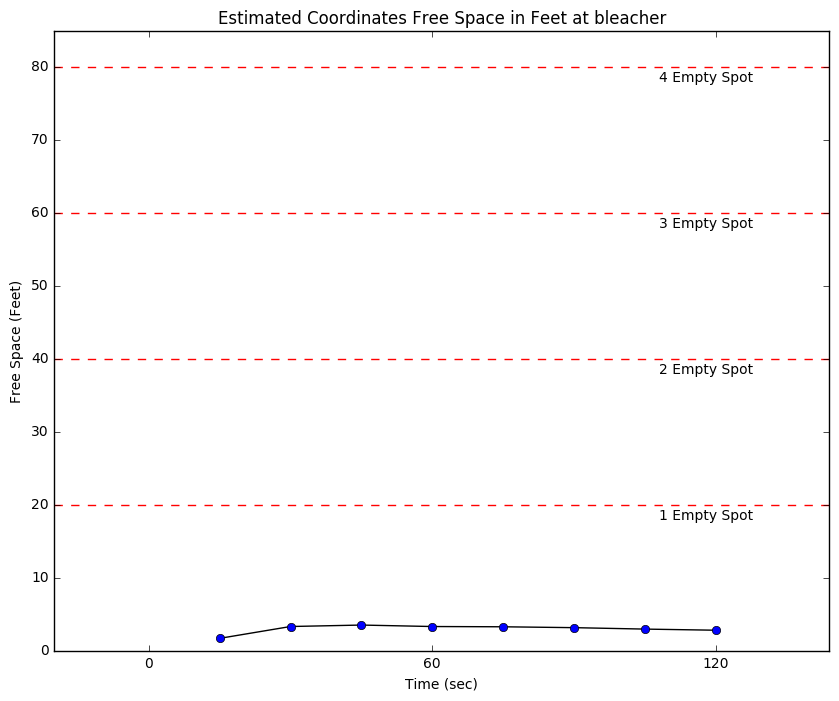

In [17]:
analysis.showEstDistFreeSpaceGraph(arrayTotalFreeSpaceInEstDist, frameNum, "bleacher")

In [ ]:
print allParking.coordOfFreeSpaces

def pixelsToEstCoord(freeSpaceArray):
    largeArray = []
    for xcoord in freeSpaceArray:
#         print "xcoord array: ", xcoord
        extrapArray = []
        for x in range(len(xcoord)):
            extrapArray.append(analysis.extrapCoordinates(xcoord[x]))
#         print "ExtrapArray: ", extrapArray
        largeArray.append(extrapArray)
    print "largeArray: ", largeArray
    return largeArray

pixelsToEstCoord(allParking.coordOfFreeSpaces)

In [33]:
#Thanks Sam for the help with this part! --Michelle

# sp0raw = np.array([8.0, 76.75, 145.5, 214.25, 283.0, 303.0, 
#         391.25, 479.5, 567.75, 656.0, 670.0, 749.75,
#         829.50, 909.25, 989.0, 1000.0, 1075.00, 1150.0, 
#         1225.0, 1300.0, 1306.0, 1352.75, 1399.5, 1446.25,
#         1493.0, 1505.0, 1528.25, 1551.50, 1574.75, 1598.0])

# #rounded scalefactors
# scaleFactor = np.array([1.25, 1.17, 1.17, 1.17, 1.16, 
#         1.12, 1.07, 1.04, 1.02, 
#         1.01, 1.0, 1.00, 1.00, 1.00,
#         1.00, 1.0, 1.00, 1.01, 1.01,
#         1.02, 1.02, 1.04, 1.06, 1.09,
#         1.11, 1.10, 1.14, 1.17, 1.21,
#         1.24])

sp0raw = np.array([78, 212.25, 346.5, 480.75, 615,
                  635, 771.75, 908.5, 1045.25, 1182,
                  1203, 1316.5, 1430, 1543.5, 1657])

# scaleFactor = np.array([0.897, 0.971, 0.988, 0.996, 1.000,
#                        1.0, 0.999, 0.998, 0.998, 0.998,
#                        0.998, 1.015, 1.029, 1.042, 1.053])

scaleFactor = np.array([0.8974358974, 0.9717314488, 0.9884559885, 0.9958398336, 1,
                        1, 0.9993521218, 0.9988992845, 0.9985649366, 0.9983079526,
                        0.9975062344, 1.015001899, 1.0297202797, 1.0422740525, 1.0531080266])

# scaleFactor = np.array([1.25, 1.1726384364820848, 1.168384879725086, 1.1668611435239207, 1.1660777385159011, 
#         1.1221122112211221, 1.073482428115016, 1.0427528675703859, 1.0215763980625274, 
#         1.0060975609756098, 1.0, 1.0003334444814937, 1.0006027727546716, 1.0008248556502612,
#         1.0010111223458038, 1.0, 1.0046511627906978, 1.008695652173913, 1.0122448979591836,
#         1.0153846153846153, 1.0183767228177643, 1.0423211975605249, 1.064665952125759, 1.0855661192739845,
#         1.1051574012056262, 1.1029900332225913, 1.138557173237363, 1.1730583306477602, 1.2065407207493253,
#         1.2390488110137672])



sqrsp0 = np.square(sp0raw)
ones = np.ones_like(sp0raw)

X = np.stack([sp0raw, sqrsp0, ones], axis=1)
print X.shape

w = np.linalg.solve(X.T.dot(X), X.T.dot(scaleFactor))
print w

# test = np.array([989, 989**2, 1])
# test = np.array([635, 635**2, 1])
test = np.array([1657, 1657**2, 1])

# print wsub
ytest = test.dot(w)

print ytest
print ytest*1657

# (30, 3)
# [ -6.41328433e-04   3.65880005e-07   1.26635656e+00]



(15, 3)
[  9.89468130e-05  -2.32858803e-08   9.34503401e-01]
1.034523416
1714.20530032


[[78.0, 6084.0, 1], [212.25, 45050.0625, 1], [346.5, 120062.25, 1], [480.75, 231120.5625, 1], [615.0, 378225.0, 1], [635.0, 403225.0, 1], [771.75, 595598.0625, 1], [908.5, 825372.25, 1], [1045.25, 1092547.5625, 1], [1182.0, 1397124.0, 1], [1203.0, 1447209.0, 1], [1316.5, 1733172.25, 1], [1430.0, 2044900.0, 1], [1543.5, 2382392.25, 1], [1657.0, 2745649.0, 1]]


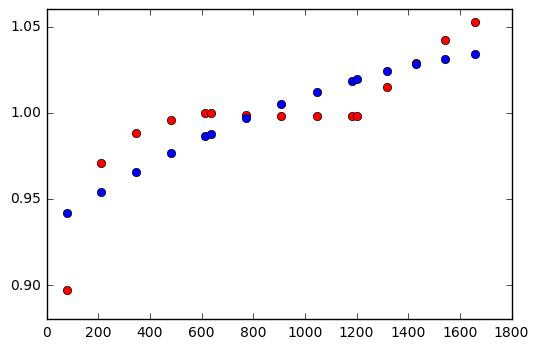

In [20]:
array = []
for x in sp0raw:
    array.append([x, x**2, 1])
    
print array
nparray = np.array(array)

plt.plot(sp0raw, scaleFactor, 'ro')
plt.plot(sp0raw, nparray.dot(w), 'bo')

In [17]:
for spots in range(len(allParking.allSpots)):
    print allParking.getSpotCentroid(spots)

[167, 506]
[496, 516]
[833, 518]
[1122, 514]
[1374, 518]
[1531, 511]


In [50]:
def dist(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)

for spots in allParking.allSpots:
    print dist(spots.staticBbox[2][0], spots.staticBbox[3][0], spots.staticBbox[2][1], spots.staticBbox[3][1])

275.147233313
353.090639921
319.014106271
300.006666593
187.066832977
93.2630687893


In [51]:
sum([353, 319, 300, 187])/4

289

In [ ]:
allimgs = sorted(glob.glob('./04-26_13.17.02/*.jpg'))
for frameNum in range(len(allimgs)):
    im = cv2.imread("{0}".format(allimgs[frameNum]))
    rows, cols, color = im.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 2, 1)
    dst = cv2.warpAffine(im, M, (cols, rows))
    print "frameName: ", allimgs[frameNum][-10:]
    cv2.imwrite("/home/ubuntu/Parking/rotate/13.17/{0}".format(allimgs[frameNum][-10:]), dst)